# Analyze the HNN lipson task
(Work in progress)

In [58]:
import torch, time, sys
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

EXPERIMENT_DIR = './experiment-lipson'
sys.path.append(EXPERIMENT_DIR)

from data import get_dataset
from nn_models import MLP
from hnn import HNN
from utils import L2_loss

## Set some notebook constants

In [59]:
DPI = 120
FORMAT = 'png'
LINE_SEGMENTS = 10
ARROW_SCALE = 30 # 100 for pend-sim, 30 for pend-real
ARROW_WIDTH = 6e-3
LINE_WIDTH = 2

def get_args():
    return {'input_dim': 2,
         'hidden_dim': 200,
         'learn_rate': 1e-3,
         'nonlinearity': 'tanh',
         'field_type': 'solenoidal',
         'total_steps': 2000,
         'print_every': 200,
         'name': 'pend-real',
         'gridsize': 10,
         'seed': 0,
         'save_dir': './{}'.format(EXPERIMENT_DIR),
         'fig_dir': './figures'}

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

## Inspect the dataset

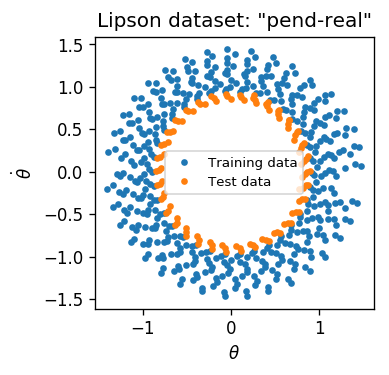

In [60]:
args = ObjectView(get_args())
np.random.seed(args.seed)
data = get_dataset(args.name, args.save_dir)

plt.figure(figsize=[3,3], dpi=DPI)
plt.plot(data['x'][:,0], data['x'][:,1], '.', label='Training data')
plt.plot(data['test_x'][:,0], data['test_x'][:,1], '.', label='Test data')
plt.title('Lipson dataset: "{}"'.format(args.name))
plt.xlabel('$\\theta$') ; plt.ylabel('$\dot \\theta$')
plt.legend(fontsize=8)
plt.show()

## Construct models

In [61]:
def get_model(args, baseline):
    output_dim = args.input_dim if baseline else 2
    nn_model = MLP(args.input_dim, args.hidden_dim, output_dim, args.nonlinearity)
    model = HNN(args.input_dim, differentiable_model=nn_model,
              field_type=args.field_type, baseline=baseline)
    
    label = 'baseline' if baseline else 'hnn'
    path = "{}/{}-{}.tar".format(args.save_dir, args.name, label)
    model.load_state_dict(torch.load(path))
    return model

base_model = get_model(args, baseline=True)
hnn_model = get_model(args, baseline=False)

## Visualize HNN scalar field

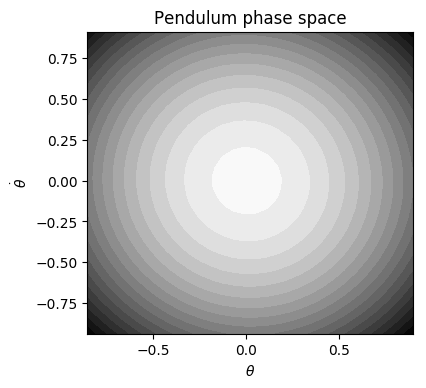

In [62]:
def get_range(data):
    xmin, xmax = data['test_x'][:,0].min(), data['test_x'][:,0].max()
    dxmin, dxmax = data['test_x'][:,1].min(), data['test_x'][:,1].max()
    return (xmin, xmax, dxmin, dxmax)

def get_mesh_inputs(data, gridsize=10):
    xmin, xmax, dxmin, dxmax = get_range(data)
    
    mesh_x, mesh_dx = np.meshgrid(np.linspace(xmin, xmax, gridsize), np.linspace(dxmin, dxmax, gridsize))
    np_mesh_inputs = np.stack([mesh_x.flatten(), mesh_dx.flatten()]).T
    mesh_inputs = torch.tensor( np_mesh_inputs, requires_grad=True, dtype=torch.float32)
    return mesh_inputs

# get scalar fields
gridsize = 30
mesh_inputs = get_mesh_inputs(data, gridsize)
X = mesh_inputs.reshape(gridsize, gridsize, 2)[...,0].detach().data.numpy()
dX = mesh_inputs.reshape(gridsize, gridsize, 2)[...,1].detach().data.numpy()

F1, F2 = hnn_model.forward(mesh_inputs)
np_F2 = F2.data.numpy().reshape(gridsize,gridsize)

# plot
fig = plt.figure(figsize=(4.2, 4), facecolor='white', dpi=100)
ax = fig.add_subplot(1, 1, 1, frameon=True)
plt.contourf(X, dX, np_F2, cmap='gray_r', levels=20)
ax.set_xlabel("$\\theta$") ; ax.set_ylabel("$\dot \\theta$")
plt.title("Pendulum phase space")

plt.show()

## Integrate along data

In [63]:
def integrate_model(model, t_span, y0, **kwargs):
    
    def fun(t, np_x):
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).view(1,2)
        dx = model.time_derivative(x).data.numpy().reshape(-1)
        return dx

    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

In [64]:
# integrate along those fields starting from point (1,0)
t_span = [0,30]
y0 = np.asarray([0.75, 0])
kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], 1000), 'rtol': 1e-12}
base_ivp = integrate_model(base_model, t_span, y0, **kwargs)
hnn_ivp = integrate_model(hnn_model, t_span, y0, **kwargs)

## Visualize vector fields

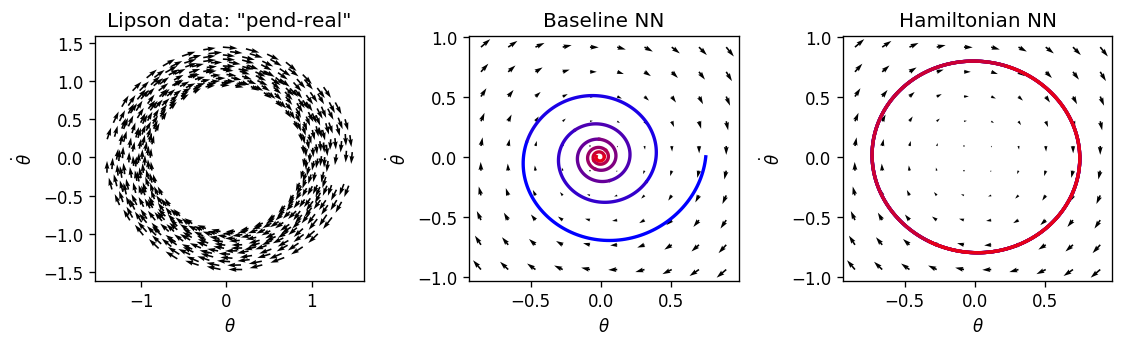

In [65]:
###### GET VECTOR FIELDS ######
mesh_inputs = get_mesh_inputs(data, gridsize=10)
input_x = mesh_inputs.detach().numpy()
base_dx = base_model.time_derivative(mesh_inputs).detach().numpy()
hnn_dx = base_model.time_derivative(mesh_inputs).detach().numpy()

###### PLOT ######
fig = plt.figure(figsize=(9.5, 3), facecolor='white', dpi=DPI)

# plot dataset
ax = fig.add_subplot(1, 3, 1, frameon=True)
ax.quiver(data['x'][:,0], data['x'][:,1], data['dx'][:,0], data['dx'][:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH)  
ax.set_xlabel("$\\theta$") ; ax.set_ylabel("$\dot \\theta$")
ax.set_title('Lipson data: "{}"'.format(args.name))

# plot baseline
ax = fig.add_subplot(1, 3, 2, frameon=True)
ax.quiver(input_x[:,0], input_x[:,1], base_dx[:,0], base_dx[:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH)  

for i, l in enumerate(np.split(base_ivp['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    ax.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)
    
ax.set_xlabel("$\\theta$") ; ax.set_ylabel("$\dot \\theta$")
ax.set_title("Baseline NN")

# plot HNN
ax = fig.add_subplot(1, 3, 3, frameon=True)
ax.quiver(input_x[:,0], input_x[:,1], hnn_dx[:,0], hnn_dx[:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH)

for i, l in enumerate(np.split(hnn_ivp['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    ax.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)
    
ax.set_xlabel("$\\theta$") ; ax.set_ylabel("$\dot \\theta$")
ax.set_title("Hamiltonian NN")

plt.tight_layout() ; plt.show()
fig.savefig('{}/{}-vfields.{}'.format(args.fig_dir, args.name, FORMAT))

## Quantitative analysis
* Choose trajectories from the test set
* Measure vector field loss at each point
* Integrate along trajectory and measure mean loss between points

In [66]:
# get trajectory of true test data
t_eval = np.squeeze( data['test_t'][:-1] - data['test_t'][:-1].min() )
t_span = [t_eval.min(), t_eval.max()]
x0 = data['test_x'][0]
true_x = data['test_x']
true_dx = data['test_dx']

# integrate along baseline vector field
base_path = integrate_model(base_model, t_span, x0, t_eval=t_eval)
base_x = base_path['y'].T
_tmp = torch.tensor( true_x, requires_grad=True, dtype=torch.float32)
base_dx = base_model.time_derivative(_tmp).data.numpy()

# integrate along HNN vector field
hnn_path = integrate_model(hnn_model, t_span, x0, t_eval=t_eval)
hnn_x = hnn_path['y'].T
_tmp = torch.tensor( true_x, requires_grad=True, dtype=torch.float32)
hnn_dx = hnn_model.time_derivative(_tmp).data.numpy()


#### ENERGY FUNCTIONS ####
def kinetic_energy(theta_dot):
    m, l = 1, 1
    return .5 * m * l**2 * theta_dot**2

def potential_energy(theta):
    m, g, l = 1, 1, 1
    return m * g * l * (1-np.cos(theta))

def total_energy(x):
    return kinetic_energy(x[:,1]) + potential_energy(x[:,0])

true_e = total_energy(true_x)
base_e = total_energy(base_x)
hnn_e = total_energy(hnn_x)

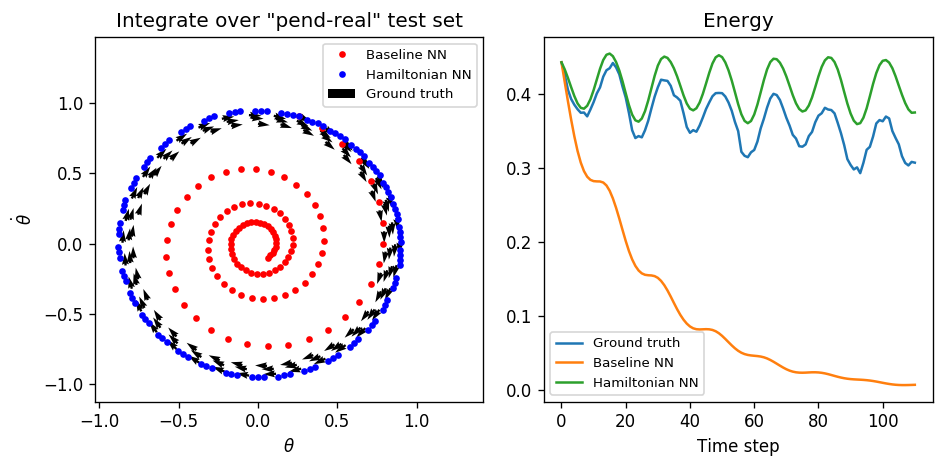

In [67]:
# plotting
fig = plt.figure(figsize=[8,4], dpi=DPI)
plt.subplot(1,2,1)
plt.title('Integrate over "{}" test set'.format(args.name))
plt.xlabel("$\\theta$") ; plt.ylabel("$\dot \\theta$")

plt.quiver(true_x[:,0], true_x[:,1], base_dx[:,0], base_dx[:,1], color='black',
           scale=ARROW_SCALE, width=ARROW_WIDTH, label='Ground truth')
plt.plot(base_x[:,0], base_x[:,1], 'r.', label='Baseline NN')
plt.plot(hnn_x[:,0], hnn_x[:,1], 'b.', label='Hamiltonian NN')

xmin, xmax, ymin, ymax = get_range(data)
rx, ry = xmax-xmin, ymax-ymin
plt.xlim(xmin - .1*rx, xmax + .3*rx)
plt.ylim(ymin - .1*ry, ymax + .3*ry)
plt.legend(fontsize=8)

plt.subplot(1,2,2)
plt.title('Energy')
plt.xlabel('Time step')
plt.plot(true_e, label='Ground truth')
plt.plot(base_e, label='Baseline NN')
plt.plot(hnn_e, label='Hamiltonian NN')
plt.legend(fontsize=8)

plt.tight_layout() ; plt.show()
fig.savefig('{}/{}-integration.{}'.format(args.fig_dir, args.name, FORMAT))

## Quantitative analysis

In [68]:
def np_L2_loss(x, xhat):
    return np.mean( (x-xhat)**2 )

base_test = np_L2_loss(true_dx, base_dx)
hnn_test = np_L2_loss(true_dx, hnn_dx)
base_energy = np_L2_loss(true_e, base_e)
hnn_energy = np_L2_loss(true_e, hnn_e)

print("Baseline NN test loss: {:.4e}\nHamiltonian NN test loss: {:.4e}"
      .format(
          base_test,
          hnn_test
     ))

print("\nBaseline NN energy MSE: {:.4e}\nHamiltonian NN energy MSE: {:.4e}"
      .format(
          base_energy,
          hnn_energy
     ))

Baseline NN test loss: 1.4463e-03
Hamiltonian NN test loss: 5.7511e-03

Baseline NN energy MSE: 7.8300e-02
Hamiltonian NN energy MSE: 2.3403e-03
